In [1]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from InstanceNormalization import *
from keras.callbacks import TensorBoard, ModelCheckpoint
import tensorflow as tf
from keras.utils import np_utils
from keras.layers import Layer
import os
import keras.backend as K
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints
from keras.regularizers import l1, l2
import numpy as np

import pylab as pl
import matplotlib.cm as cm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy.ma as ma

import theano

Using TensorFlow backend.


## Parameters

In [2]:
NORM = True
DROPOUT = False
batch_size =  32
num_classes = 10
epochs = 50
lamdas = [1e-4, 1e-3, 1e-2, 1e-1]

NUM_PLOT_BINS = 30


## Preprocessing Data

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test_samples')

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test_samples


## Model Definition

In [4]:
def base_model(reg):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:],kernel_regularizer=reg))
    model.add(InstanceNormalization()) if NORM else None
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3, 3),kernel_regularizer=reg))
    model.add(InstanceNormalization()) if NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25)) if DROPOUT else None

    model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=reg))
    model.add(InstanceNormalization()) if NORM else None
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(512,kernel_regularizer=reg))
    model.add(InstanceNormalization()) if NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5)) if DROPOUT else None
    
    model.add(Dense(num_classes,kernel_regularizer=reg))
    model.add(Activation('softmax'))

    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## Weight Visualization Functions

In [5]:
import pylab as pl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma

# Visualize weights 
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[-1]
    imshape = imgs.shape[0:-1]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[:,:,i]
    return mosaic

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)

# plots histogram of weights
def plot_weights(flat_weights, plot_file_name, title_name):
    fig = pl.figure()
    ax = fig.add_subplot(111)
    pl.suptitle("Weights histogram (1st Conv layer): " + title_name)
    ax.hist(flat_weights, NUM_PLOT_BINS, color='green', alpha=0.8)
    pl.show()
    print("Saving histogram of weights in:", plot_file_name)
    fig.savefig(plot_file_name)
    pl.close(fig)


## IN

W shape :  (3, 3, 3, 32)


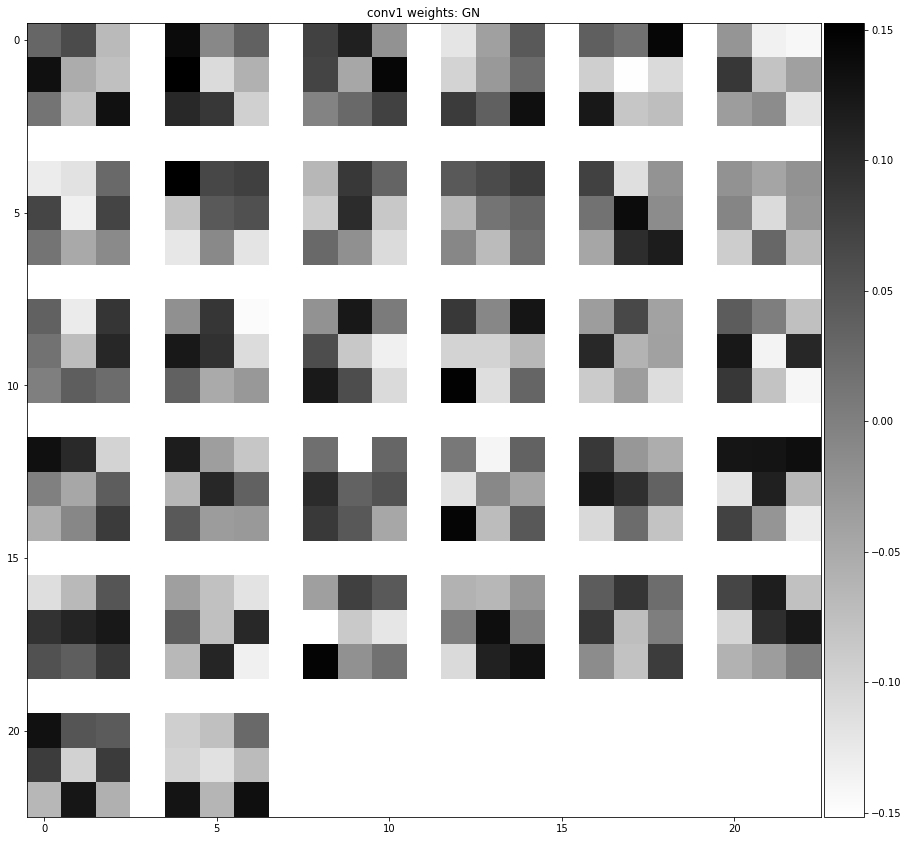

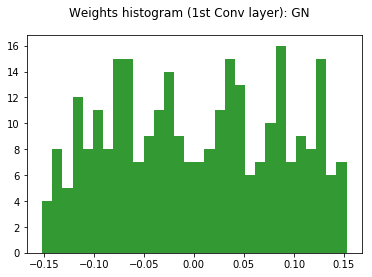

Saving histogram of weights in: GN.png


In [9]:
NORM = True
model = base_model(None)
#model.summary()
log_dir = "./IN"

if os.path.isfile(log_dir + '/weights.h5'):
    tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False)
    model.load_weights(log_dir + '/weights.h5')
else:
    tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False)

    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test),
                    shuffle=True, callbacks=[tensorboard], verbose = 1)
    model.save_weights('./IN/weights.h5')


# Visualize weights of first conv layer
W = model.layers[0].get_weights()[0]
W = np.squeeze(W)
print("W shape : ", W.shape)

pl.figure(figsize=(15, 15))
pl.title('conv1 weights: GN')
nice_imshow(pl.gca(), make_mosaic(W[0], 6, 6), cmap=cm.binary)


# Visualize histograms of weights
plot_weights(W[0].reshape(-1,1), 'IN.png', 'IN')


K.clear_session()

## GN + L1

Lambda =  0.0001
W shape :  (3, 3, 3, 32)


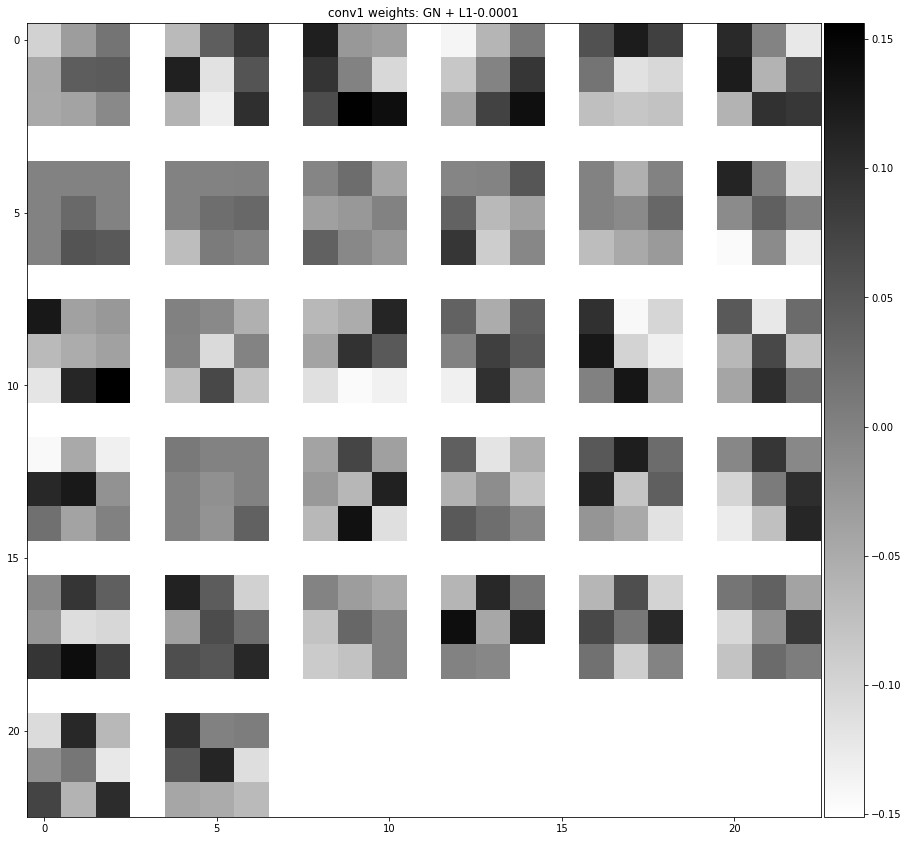

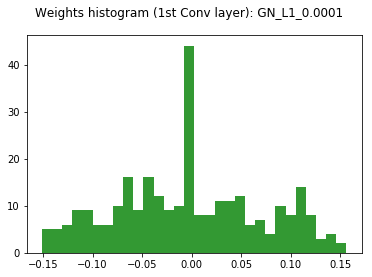

Saving histogram of weights in: GN_L1_0.0001.png
Lambda =  0.001
W shape :  (3, 3, 3, 32)


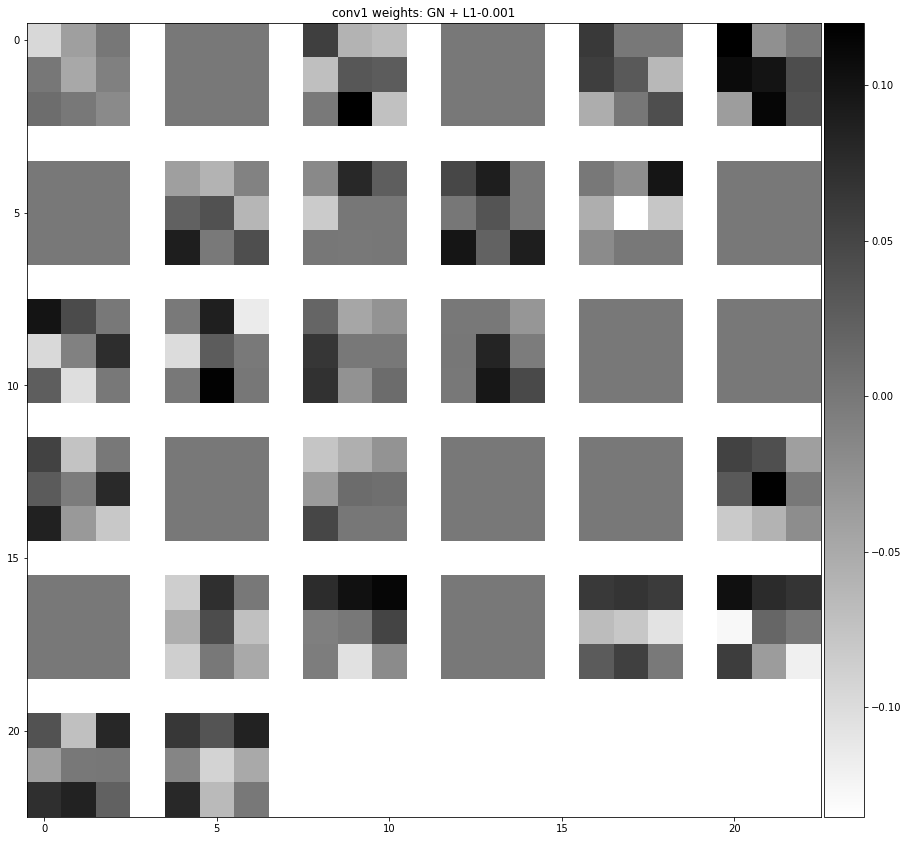

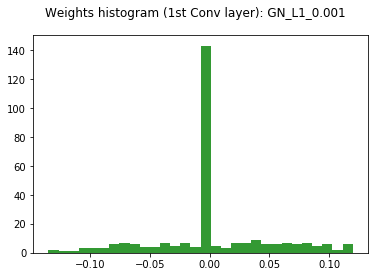

Saving histogram of weights in: GN_L1_0.001.png
Lambda =  0.01
W shape :  (3, 3, 3, 32)


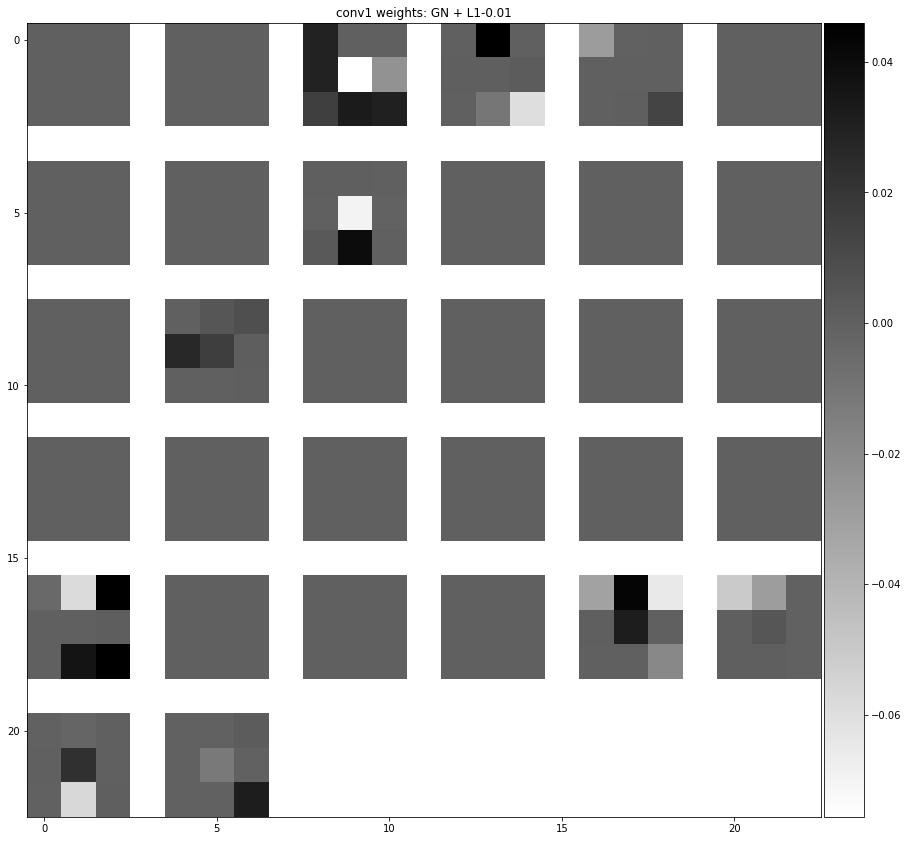

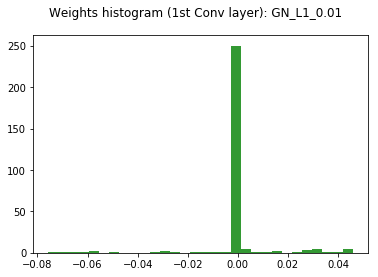

Saving histogram of weights in: GN_L1_0.01.png
Lambda =  0.1
W shape :  (3, 3, 3, 32)


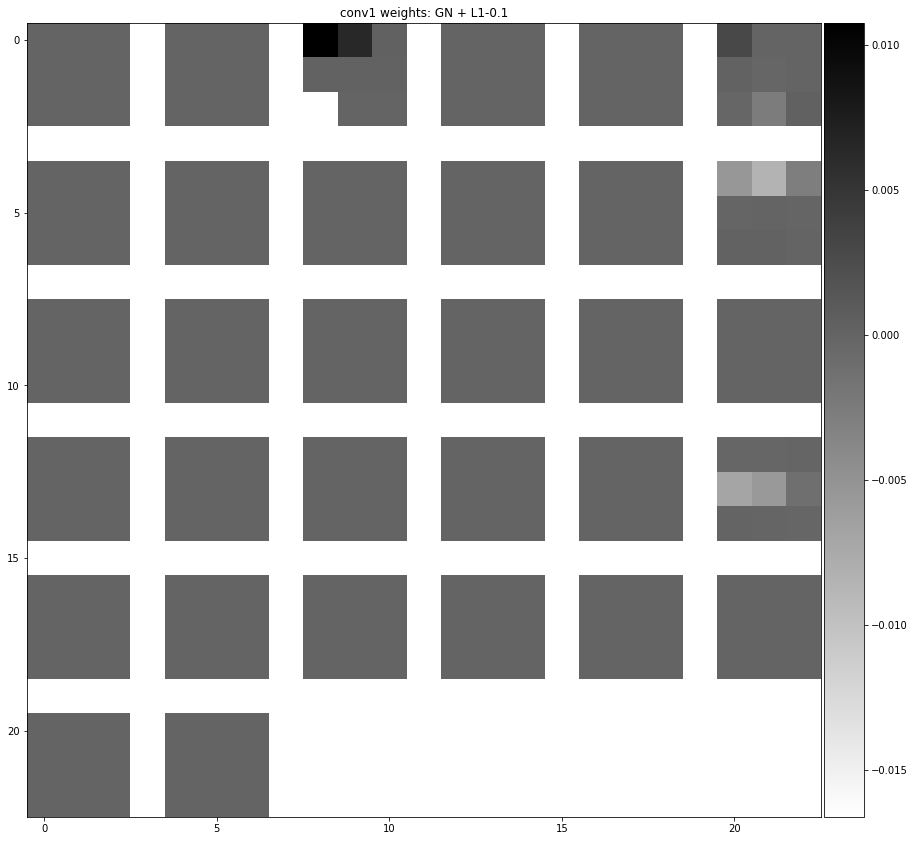

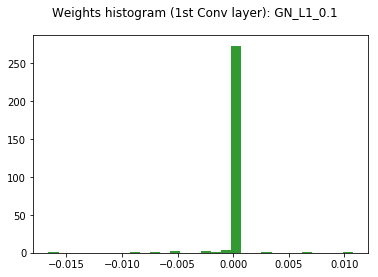

Saving histogram of weights in: GN_L1_0.1.png


In [10]:
for lam in lamdas:
    print ('Lambda = ', str(lam))
    lasso = l1(lam)
    model = base_model(lasso)
#    model.summary()
    log_dir = os.path.join("./IN_L1", str(lam))
    if os.path.isfile('IN_L1/weights_' + str(lam) + '.h5'):
        tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False)
        model.load_weights('IN_L1/weights_' + str(lam) + '.h5')
    else:    
        tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False)

        model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test),
                        shuffle=True, callbacks=[tensorboard], verbose = 1)
        
        model.save_weights('./IN_L1/weights' + str(lam) + '.h5')


    # Visualize weights of first conv layer
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)
    print("W shape : ", W.shape)

    pl.figure(figsize=(15, 15))
    pl.title('conv1 weights: IN + L1-' + str(lam))
    nice_imshow(pl.gca(), make_mosaic(W[0], 6, 6), cmap=cm.binary)


    # Visualize histograms of weights
    plot_weights(W[0].reshape(-1,1), 'IN_L1_' + str(lam) + '.png', 'IN_L1_' + str(lam) )

    K.clear_session()

## GN + L2

Lambda =  0.0001
W shape :  (3, 3, 3, 32)


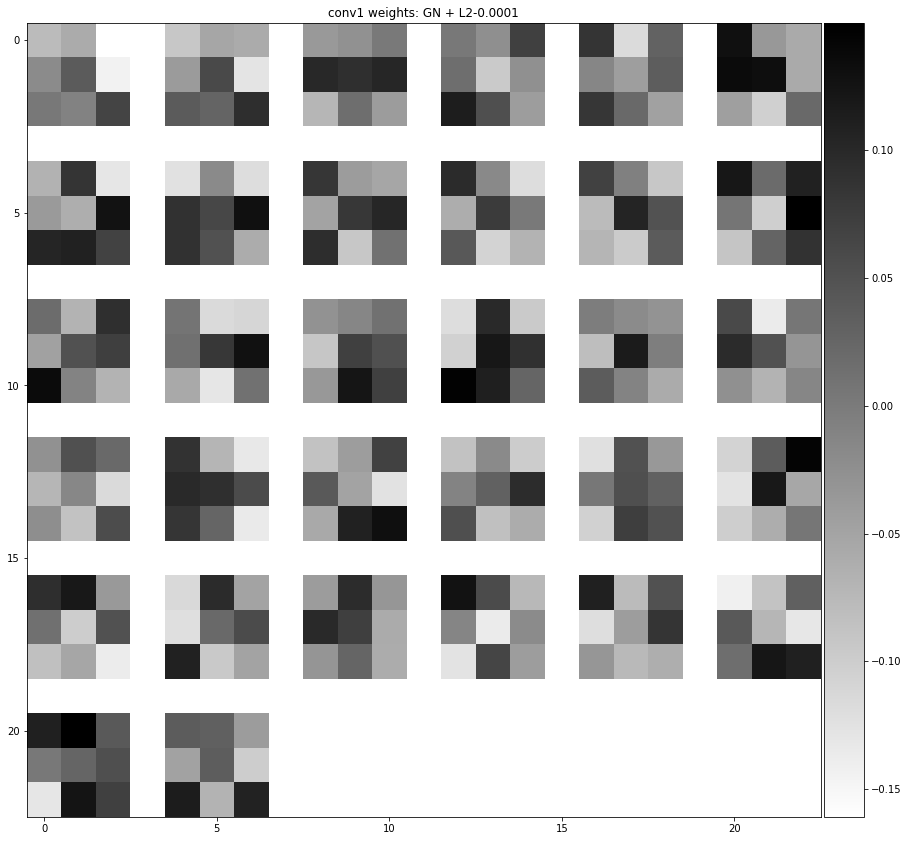

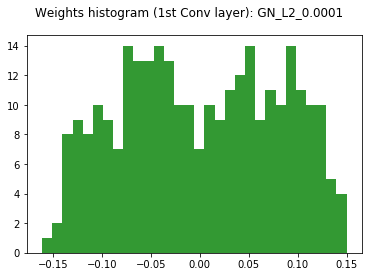

Saving histogram of weights in: GN_L2_0.0001.png
Lambda =  0.001
W shape :  (3, 3, 3, 32)


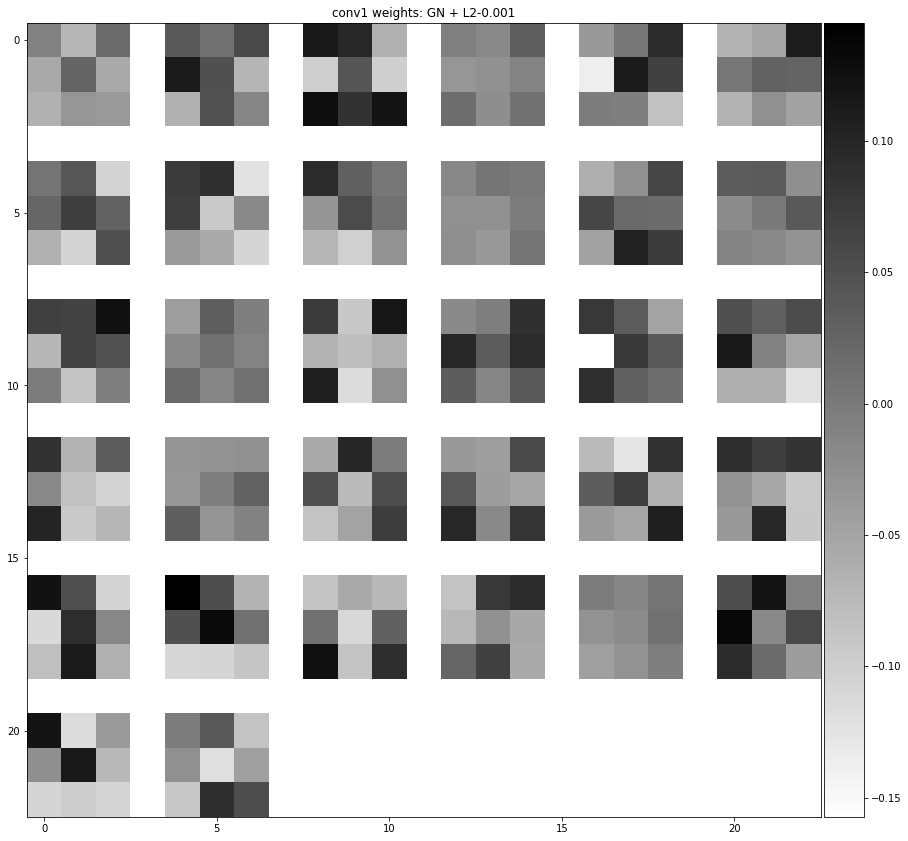

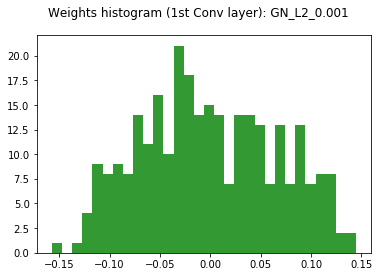

Saving histogram of weights in: GN_L2_0.001.png
Lambda =  0.01
W shape :  (3, 3, 3, 32)


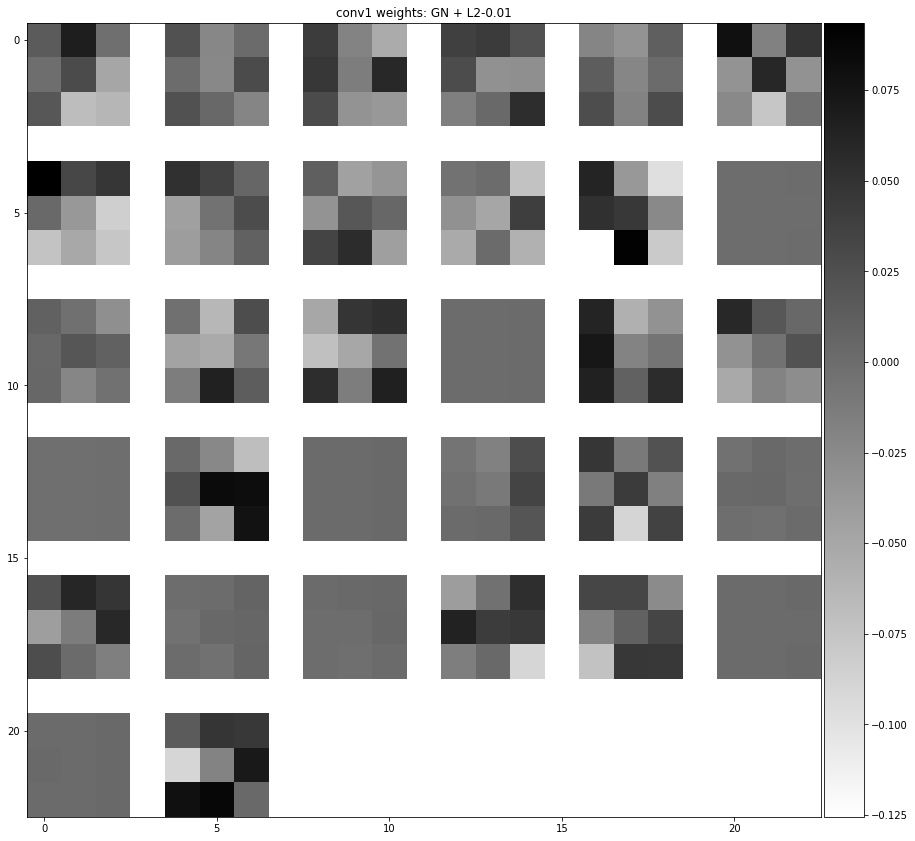

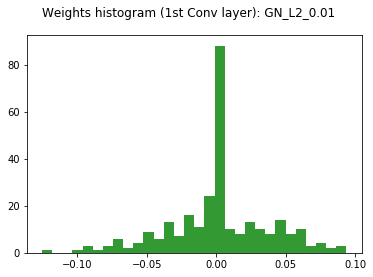

Saving histogram of weights in: GN_L2_0.01.png
Lambda =  0.1
W shape :  (3, 3, 3, 32)


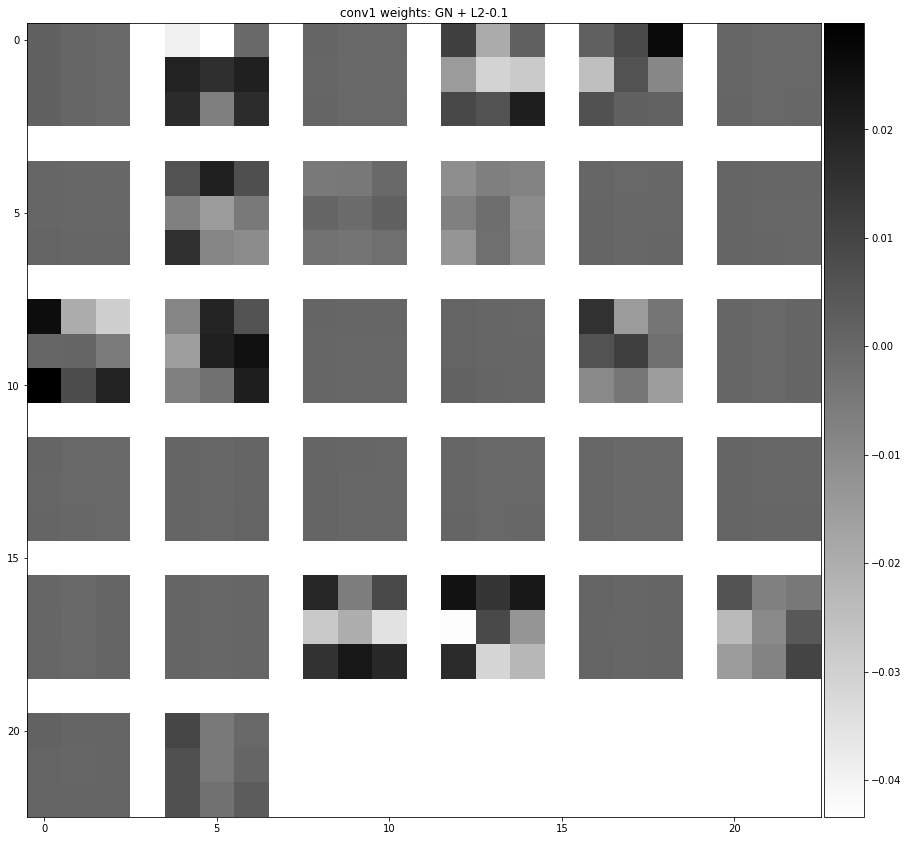

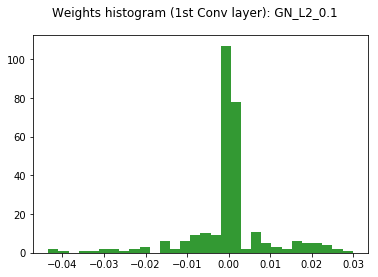

Saving histogram of weights in: GN_L2_0.1.png


In [11]:
for lam in lamdas:
    print ('Lambda = ', str(lam))
    ridge = l2(lam)
    model = base_model(ridge)
    #model.summary()
    log_dir = os.path.join("./IN_L2", str(lam))
    if os.path.isfile('IN_L2/weights_' + str(lam) + '.h5'):
        tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False)
        model.load_weights('IN_L2/weights_' + str(lam) + '.h5')
    else:    

        tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False)

        model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test),
                        shuffle=True, callbacks=[tensorboard], verbose = 1)
        model.save_weights('./IN_L2/weights' + str(lam) + '.h5')

    # Visualize weights of first conv layer
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)
    print("W shape : ", W.shape)

    pl.figure(figsize=(15, 15))
    pl.title('conv1 weights: IN + L2-' + str(lam))
    nice_imshow(pl.gca(), make_mosaic(W[0], 6, 6), cmap=cm.binary)


    # Visualize histograms of weights
    plot_weights(W[0].reshape(-1,1), 'IN_L2_' + str(lam) + '.png', 'IN_L2_' + str(lam) )
        
    K.clear_session()

## GN + Dropout + L2

Lambda =  0.0001
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W shape :  (3, 3, 3, 32)


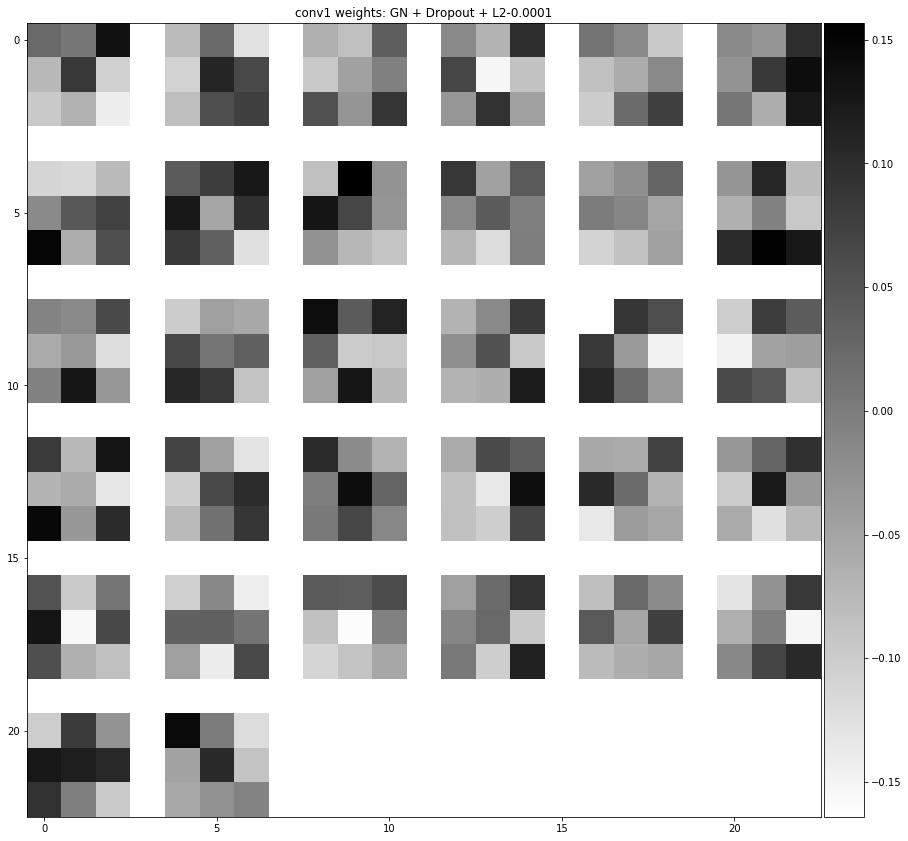

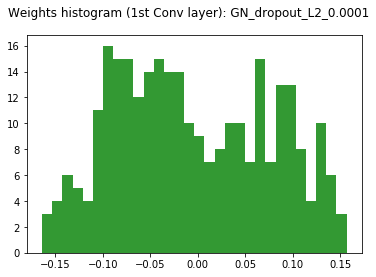

Saving histogram of weights in: GN_dropout_L2_0.0001.png
Lambda =  0.001
W shape :  (3, 3, 3, 32)


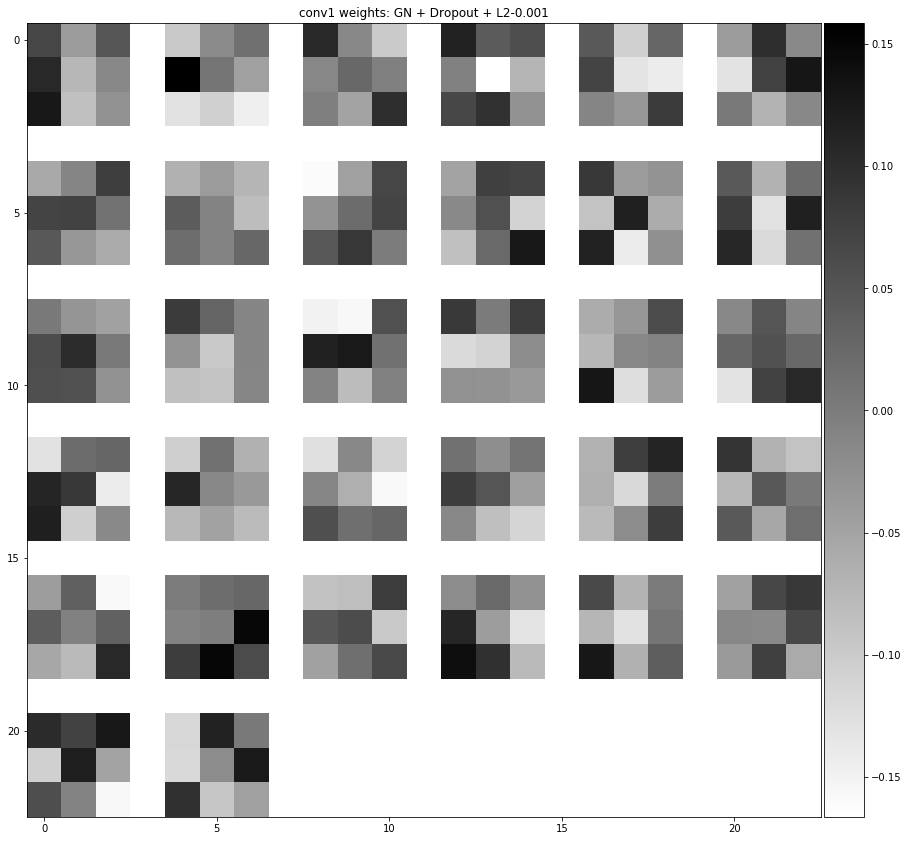

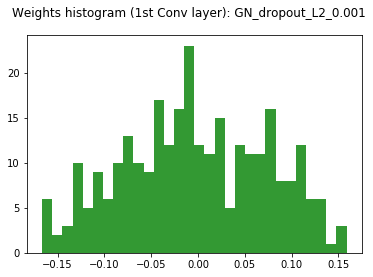

Saving histogram of weights in: GN_dropout_L2_0.001.png
Lambda =  0.01
W shape :  (3, 3, 3, 32)


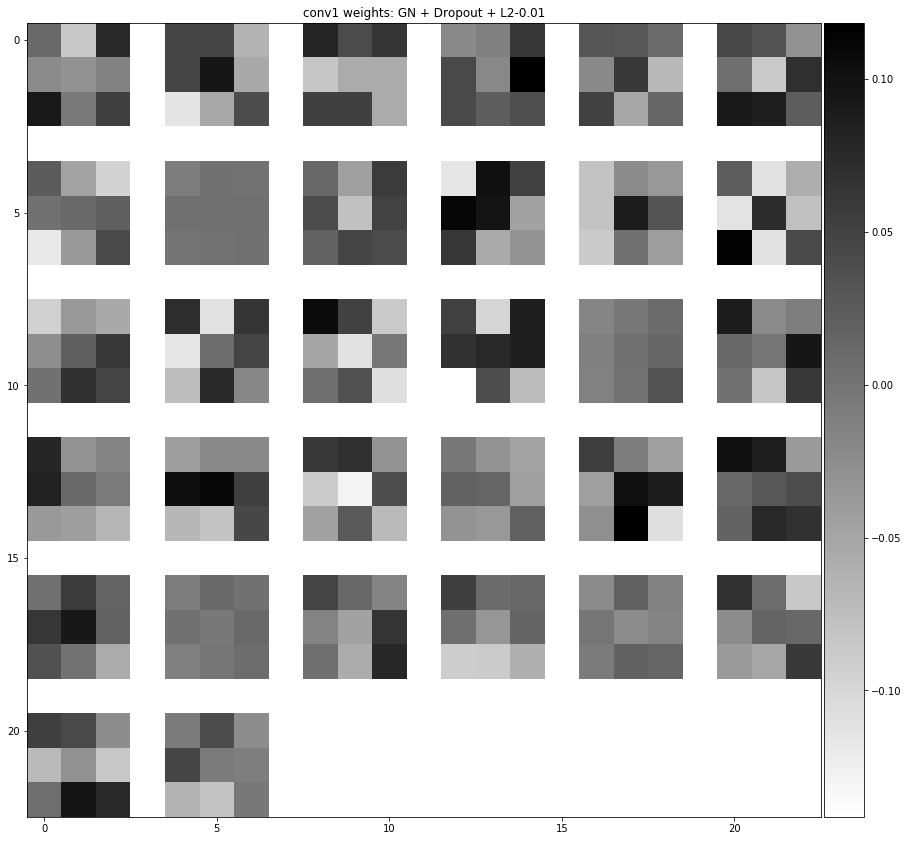

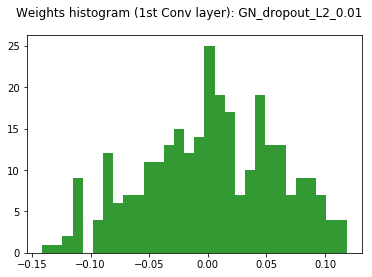

Saving histogram of weights in: GN_dropout_L2_0.01.png
Lambda =  0.1
W shape :  (3, 3, 3, 32)


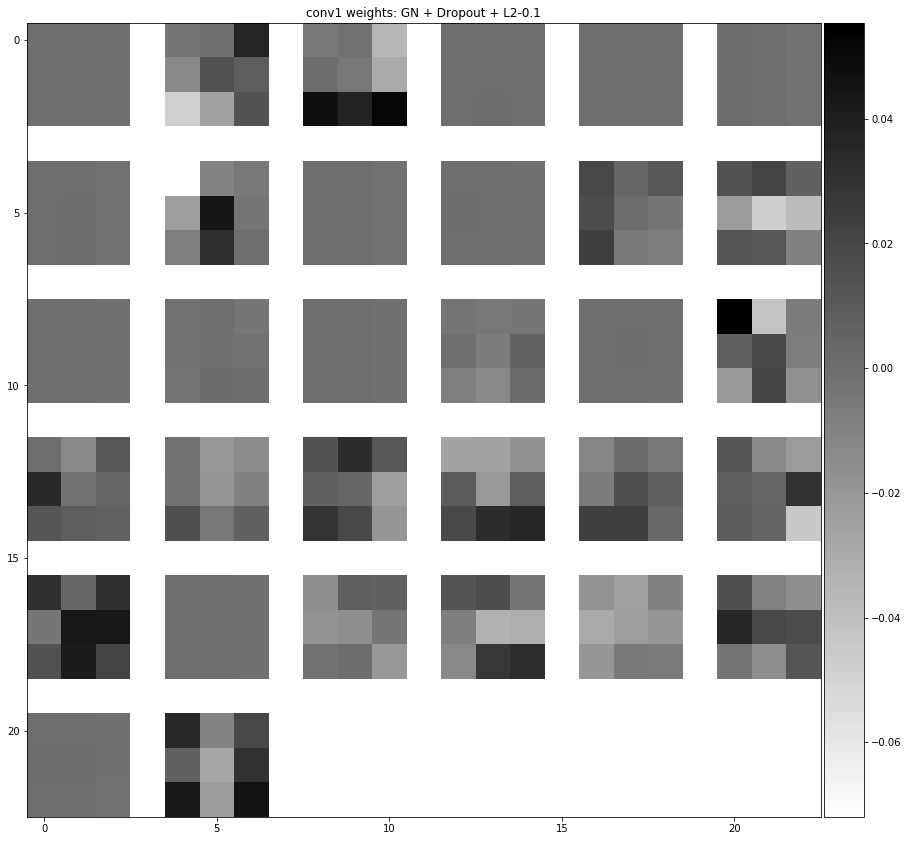

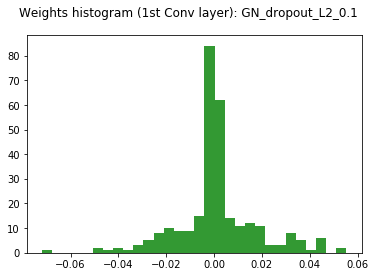

Saving histogram of weights in: GN_dropout_L2_0.1.png


In [12]:
DROPOUT = True
for lam in lamdas:
    print ('Lambda = ', str(lam))
    ridge = l2(lam)
    model = base_model(ridge)
    #model.summary()
    log_dir = os.path.join("./IN_dropout_L2", str(lam))

    if os.path.isfile('IN_dropout_L2/weights_' + str(lam) + '.h5'):
        tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False)
        model.load_weights('IN_dropout_L2/weights_' + str(lam) + '.h5')
    else:    

        tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False)

        model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test),
                        shuffle=True, callbacks=[tensorboard], verbose = 1)
        model.save_weights('./IN_dropout_L2/weights' + str(lam) + '.h5')


    # Visualize weights of first conv layer
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)
    print("W shape : ", W.shape)

    pl.figure(figsize=(15, 15))
    pl.title('conv1 weights: IN + Dropout + L2-' + str(lam))
    nice_imshow(pl.gca(), make_mosaic(W[0], 6, 6), cmap=cm.binary)


    # Visualize histograms of weights
    plot_weights(W[0].reshape(-1,1), 'IN_dropout_L2_' + str(lam) + '.png', 'IN_dropout_L2_' + str(lam) )

    K.clear_session()

## GN + Dropout + L1

Lambda =  0.0001
W shape :  (3, 3, 3, 32)


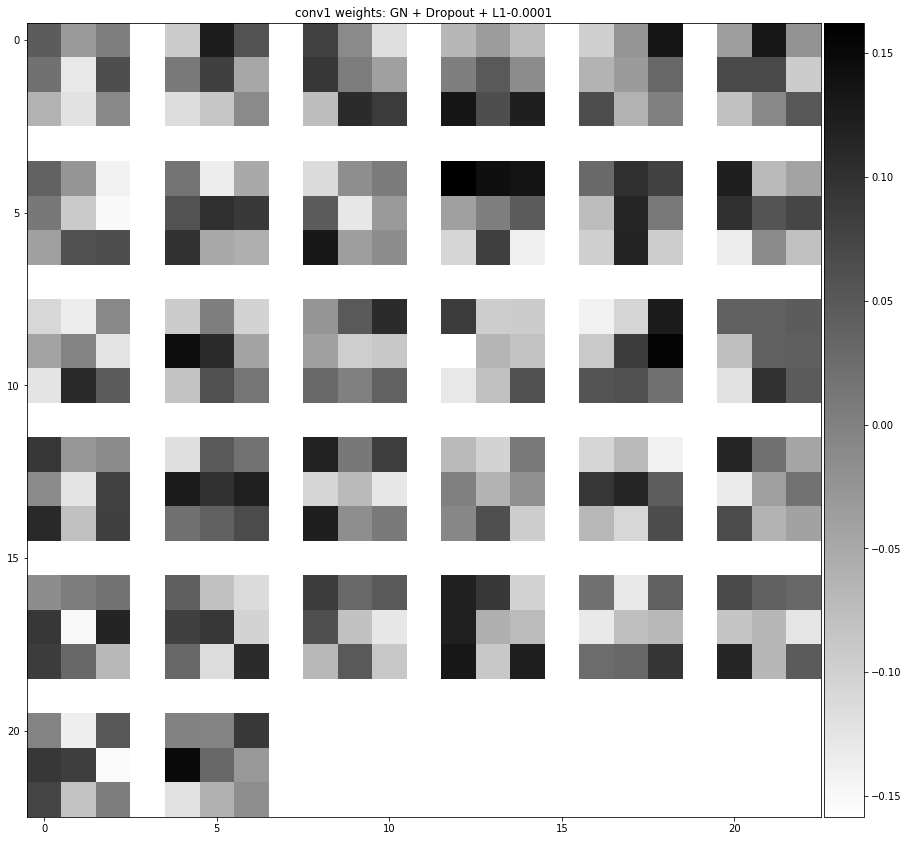

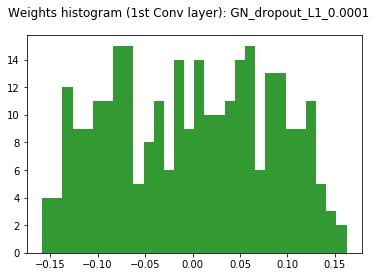

Saving histogram of weights in: GN_dropout_L1_0.0001.png
Lambda =  0.001
W shape :  (3, 3, 3, 32)


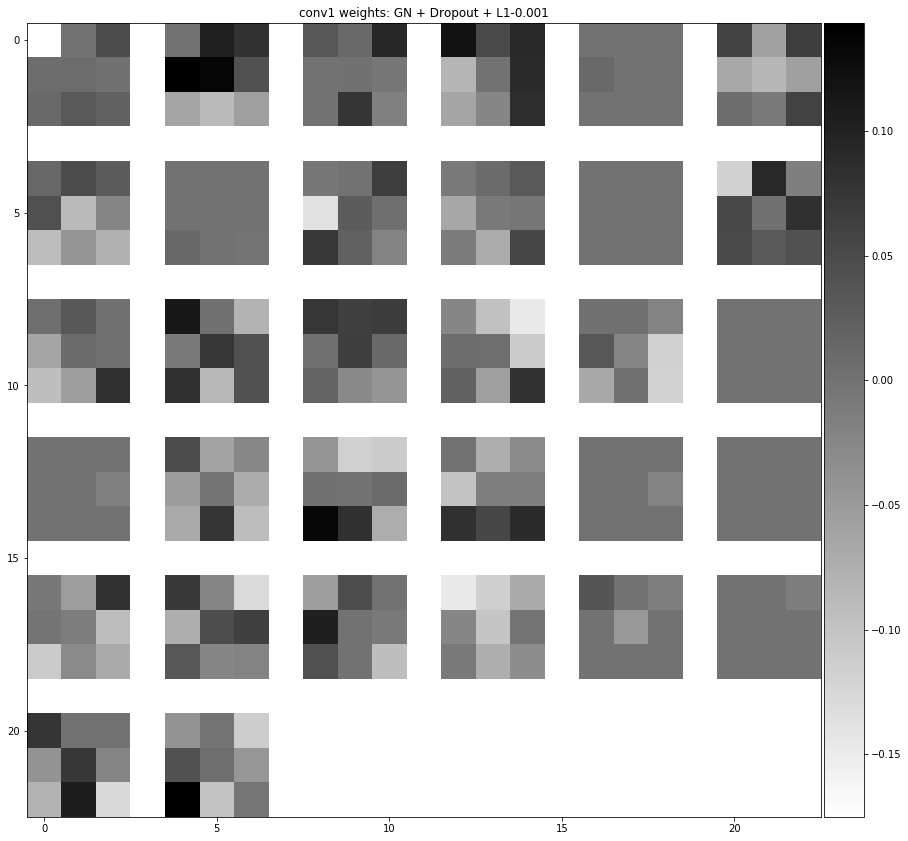

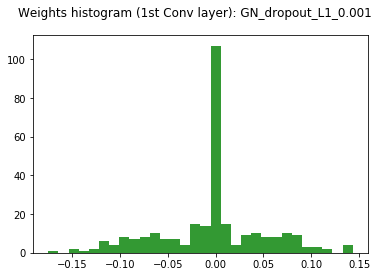

Saving histogram of weights in: GN_dropout_L1_0.001.png
Lambda =  0.01
W shape :  (3, 3, 3, 32)


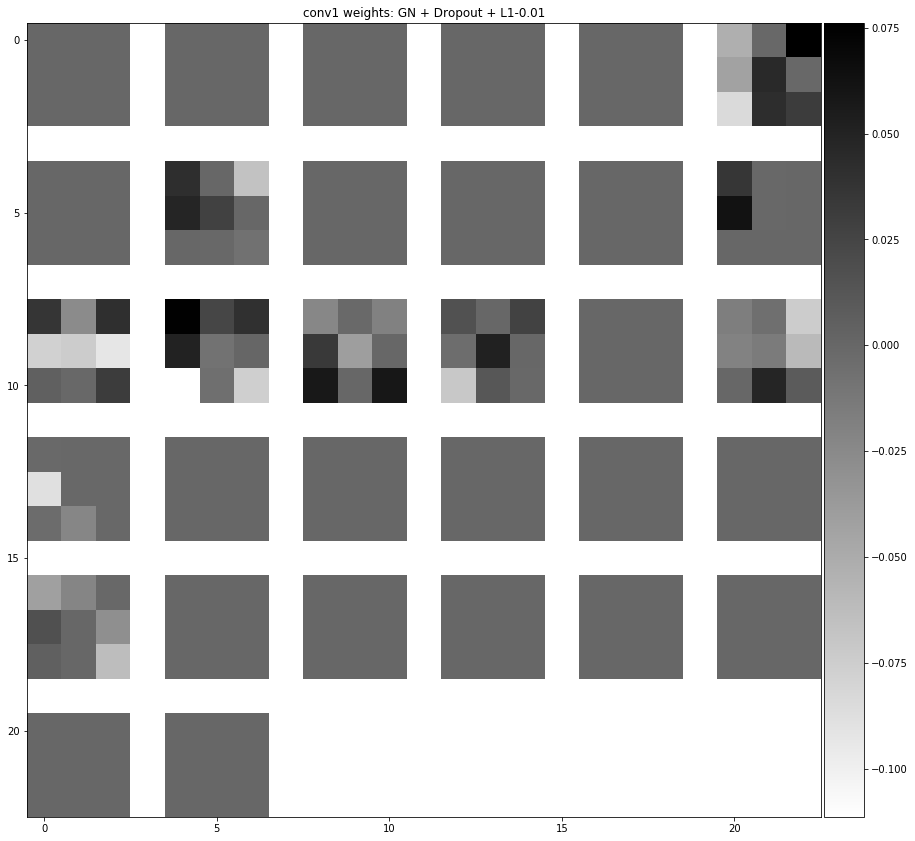

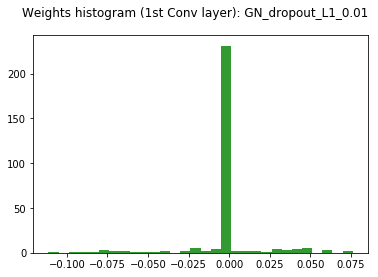

Saving histogram of weights in: GN_dropout_L1_0.01.png
Lambda =  0.1
W shape :  (3, 3, 3, 32)


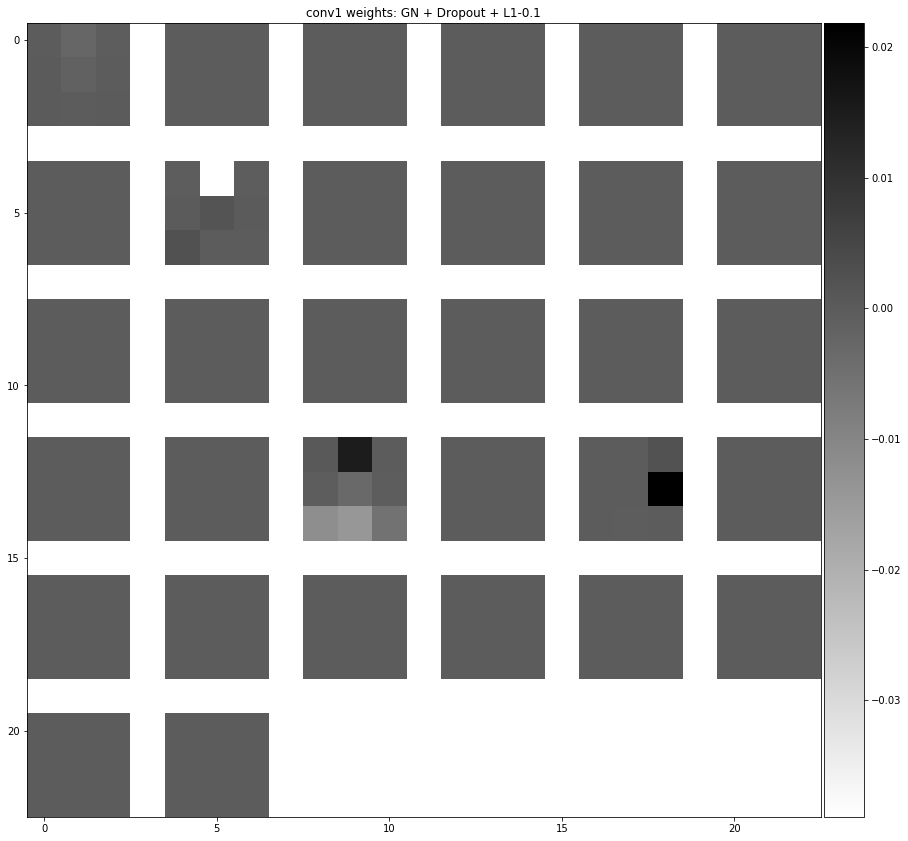

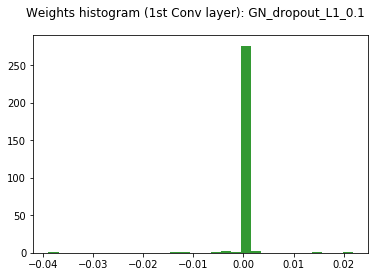

Saving histogram of weights in: GN_dropout_L1_0.1.png


In [13]:
DROPOUT = True
for lam in lamdas:
    print ('Lambda = ', str(lam))
    ridge = l1(lam)
    model = base_model(ridge)
    #model.summary()
    log_dir = os.path.join("./IN_dropout_L1", str(lam))

    if os.path.isfile('IN_dropout_L1/weights_' + str(lam) + '.h5'):
        tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False)
        model.load_weights('IN_dropout_L1/weights_' + str(lam) + '.h5')
    else:    

        tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False)

        model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test),
                        shuffle=True, callbacks=[tensorboard], verbose = 1)
        model.save_weights('./IN_dropout_L1/weights' + str(lam) + '.h5')


    # Visualize weights of first conv layer
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)
    print("W shape : ", W.shape)

    pl.figure(figsize=(15, 15))
    pl.title('conv1 weights: IN + Dropout + L1-' + str(lam))
    nice_imshow(pl.gca(), make_mosaic(W[0], 6, 6), cmap=cm.binary)


    # Visualize histograms of weights
    plot_weights(W[0].reshape(-1,1), 'IN_dropout_L1_' + str(lam) + '.png', 'IN_dropout_L1_' + str(lam) )

    K.clear_session()

## Dropout

W shape :  (3, 3, 3, 32)


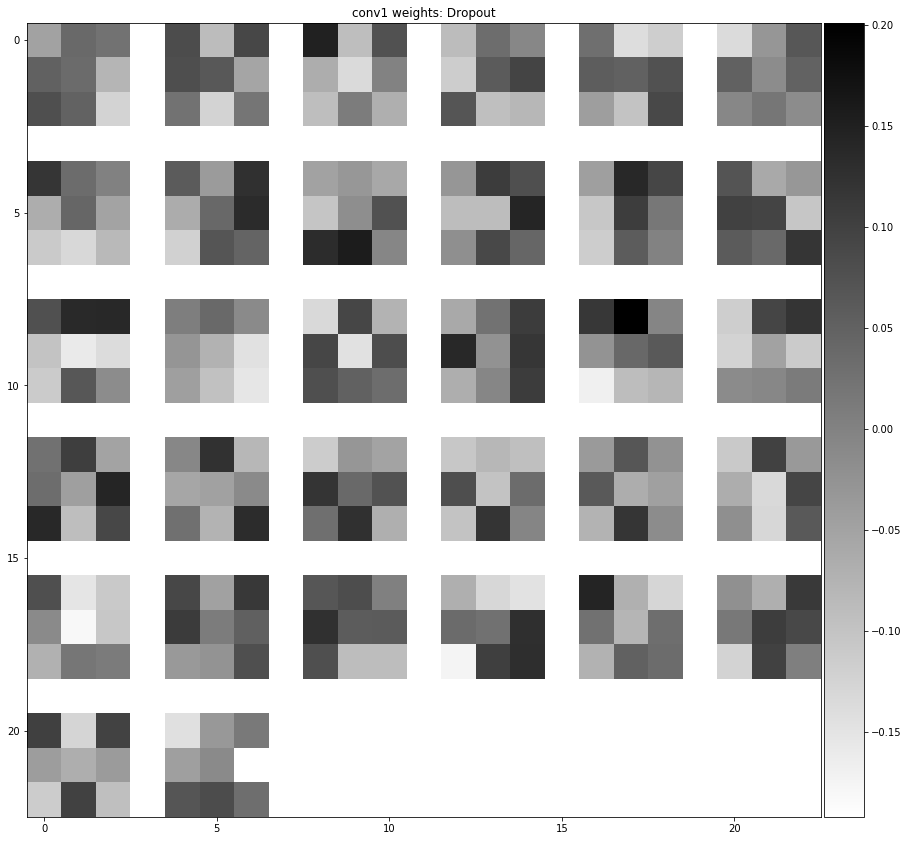

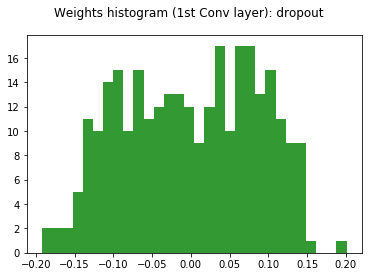

Saving histogram of weights in: dropout.png


In [14]:
DROPOUT = True
NORM = False
model = base_model(None)
#model.summary()
log_dir = os.path.join("./dropout", str(lam))
if os.path.isfile('dropout/weights.h5'):
    tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False)
    model.load_weights('dropout/weights.h5')
else:    

    tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False)

    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test),
                    shuffle=True, callbacks=[tensorboard], verbose = 1)
    model.save_weights('./dropout/weights.h5')


# Visualize weights of first conv layer
W = model.layers[0].get_weights()[0]
W = np.squeeze(W)
print("W shape : ", W.shape)

pl.figure(figsize=(15, 15))
pl.title('conv1 weights: Dropout')
nice_imshow(pl.gca(), make_mosaic(W[0], 6, 6), cmap=cm.binary)


# Visualize histograms of weights
plot_weights(W[0].reshape(-1,1), 'dropout.png', 'dropout')

K.clear_session()